In [2]:
import pandas as pd
import os
import numpy as np 
import datetime
import matplotlib.pyplot as plt
from datetime import timedelta
from random import sample
os.getcwd()

'd:\\courses\\Weaning\\COM4520-Darwin-weaing-of-ventilators\\Transformers\\data_process'

In [4]:
# Get data
names=['Time', 'ID', 'AdmissionDate', 'DischargeDate', 'CCOutcome', 'HospOutcome', 'VentMode',
       'PS_Above_PEEP', 'EPAP_PEEP', 'SET_FIO2', 'Spont_RR', 'Deadspace', 'SBI', 'P01'
       , 'PH', 'PaCO2', 'PaO2', 'LactateABG', 'HeartRate', 'ArtSystollic', 'ArtMAP', 
       'Temperature', 'empty_col']
datatypes = dtype={'Time': 'string','ID': int, 'AdmissionDate': 'string', 'DischargeDate': 'string',
                   'CCOutcome': 'string', 'HospOutcome': 'string', 'VentMode': 'string',
                   'PS_Above_PEEP': 'string', 'EPAP_PEEP': float, 'SET_FIO2': float, 'Spont_RR': float,
                   'Deadspace': float, 'SBI': 'string', 'P01': float, 'PH': float, 'PaCO2': float,
                   'PaO2': float, 'LactateABG': float, 'HeartRate': float, 'ArtSystollic': float,
                   'ArtMAP': float, 'Temperature': float, 'empty_col': 'string'}
# 'SET_FIO2': float, 'HeartRate': float, 'ArtSystollic': float, 'ArtMAP': float as it deals with NaN vals
# All cols have NaN vals, so need to set them all to string or float, so we do not use this. 
parse_dates = ['Time', 'AdmissionDate', 'DischargeDate']
# Uses v4
df = pd.read_csv('../output_weaning_data_all_v4.csv', 
                 encoding= 'unicode_escape',
                 header=0,
                 names=names,
                 dtype= datatypes
                )
unique_ids = df['ID'].unique()
unique_ids.sort()


In [5]:
def windows_missing_value(patient_df):
    score_multiplier=5.0
    missing_num = patient_df.isna().sum()
    total_num = patient_df.shape[0]
    missing_percentage=1-missing_num/total_num
    missing_percentage=missing_percentage*score_multiplier//1
    return(missing_percentage)

def get_window(patient_df,windows_size):
    #remove all the missing line for the patient
    valid_df=patient_df[patient_df['Time']!='<NA>']
    #if no data left for the patient, then return 100% missing for the patient
    if valid_df.size==0:
        return([],0)
        # return("%.2f%%"%100)
    date_time = pd.to_datetime(valid_df['Time'], format='%d/%m/%Y %H:%M')
    timestamps = date_time.map(datetime.datetime.timestamp)
    valid_df['timestamps']=timestamps
    valid_df=valid_df.sort_values(by=['timestamps'])
    date_time = pd.to_datetime(valid_df['Time'], format='%d/%m/%Y %H:%M')
    deltas = date_time.diff()[1:]
    windows=[0]
    i=0
    for delta in deltas:
        if delta == timedelta(minutes=1):
            windows[i]+=1
        else:
            windows.append(1)
            i+=1
    i=0
    windows_index=[]
    filter_windows=[]
    for window in windows:
        if window >= windows_size:
            filter_windows.append(window//windows_size*windows_size)
            windows_index.append(i)
        i+=1
    i=0
    df_index=[]#index from end of each window
    new_df=[]
    for windows_indexs in windows_index:
        df_index.append(sum(windows[:windows_indexs+1]))
        start=df_index[i]-filter_windows[i]+1
        end=df_index[i]+1
        new_df.append(valid_df[start:end])
        i+=1
    windows_count=int((sum(filter_windows))/windows_size)
    # print(filter_windows)
    # print(windows_index)
    # print(windows)
    # print(df_index)
    return(new_df,windows_count)

def getcolor(score):
    one = 255/44
    r=0.0
    g=0.0
    b=0.0
    if score<22:
        r=255
    elif score>=22 and score<34:
        r=255
        g=255-(34-score)*one*3.67
    else:
        r=255-(score-34)*one*4.4
        g=255
        
    r=r/255
    if r>1:
        r=1.0
    if r<0:
        r=0.0
        
    g=g/255
    if g>1:
        g=1.0
    if g<0:
        g=0.0
    return(r,g,b)

In [7]:
def generate_windows_df(windows_size=120,unique_ids=unique_ids):
    #generate new dataframe that includes all windows
    windows_df_list = []
    windows_count_per_patient={}#record the number of windows for each patient
    windows_size = windows_size#the window size is 2 hours right now, can be easily changed
    for id_to_keep in unique_ids:
        find_window_df = df.loc[df['ID'] == id_to_keep]
        window_for_id,windows_count = get_window(find_window_df,windows_size)
        if windows_count>0:
            windows_count_per_patient[id_to_keep]=windows_count
        windows_df_list+=window_for_id
    windows_df = pd.concat(windows_df_list, ignore_index=True)
    #print(windows_count_per_patient)#it will show the dict that stores how many windows for each patient
    return(windows_df,windows_count_per_patient)

In [8]:
def generate_windows_mark_csv(windows_size=360,drop_feature=['AdmissionDate', 'DischargeDate', 'CCOutcome', 'VentMode', 'timestamps', 'PH', 'PaCO2', 'PaO2', 'LactateABG', 'Temperature'],unique_ids=unique_ids):
    #generate new dataframe that includes all windows
    windows_df,windows_count_per_patient=generate_windows_df(windows_size=windows_size,unique_ids=unique_ids)
    
    windows_names=['ID', 'Start_Time','End_Time','AdmissionDate', 'DischargeDate', 'CCOutcome', 'HospOutcome', 'VentMode',
       'PS_Above_PEEP', 'EPAP_PEEP', 'SET_FIO2', 'Spont_RR', 'Deadspace', 'SBI', 'P01'
       , 'PH', 'PaCO2', 'PaO2', 'LactateABG', 'HeartRate', 'ArtSystollic', 'ArtMAP', 
       'Temperature', 'timestamps']

        
    windows_mark_df=pd.DataFrame(columns=windows_names)
    windows_patient = []
    for key,value in windows_count_per_patient.items():
        windows_patient+=([key]*value)
    row_time=list(windows_df['Time'])
    time_for_window=[]
    end_for_window=[]
    for i in range(len(windows_patient)):
        index=i*windows_size
        time_for_window.append(row_time[index])
        end_for_window.append(row_time[index+windows_size-1])
    windows_mark_df['ID']=windows_patient
    windows_mark_df['Start_Time']=time_for_window
    windows_mark_df['End_Time']=end_for_window

    dflist__windows = []#it stores every 120lines in the dataframe as a windows to the list
    i=0
    for id_to_keep in windows_patient:
        dflist__windows.append(windows_df[i*windows_size:(i+1)*windows_size])
        i+=1
    id_index=0
    windows_names=['AdmissionDate', 'DischargeDate', 'CCOutcome', 'HospOutcome', 'VentMode',
        'PS_Above_PEEP', 'EPAP_PEEP', 'SET_FIO2', 'Spont_RR', 'Deadspace', 'SBI', 'P01'
        , 'PH', 'PaCO2', 'PaO2', 'LactateABG', 'HeartRate', 'ArtSystollic', 'ArtMAP', 
        'Temperature', 'timestamps']
    for df_each_windows in dflist__windows:
        for feature in windows_names:
            
            miss_value_percentage=windows_missing_value(df_each_windows[feature])
            windows_mark_df.loc[id_index,feature]=miss_value_percentage
        id_index+=1
        
    drop_feature=drop_feature
    dropped_windows_mark_df=windows_mark_df.copy()#to avoid drop on the original dataframe
    dropped_windows_mark_df=dropped_windows_mark_df.drop(columns=drop_feature)
    windows_df.to_csv('windows_df_'+str(windows_size)+'.csv',index=False,header=True)
    dropped_windows_mark_df.to_csv('windows_mark_df_'+str(windows_size)+'.csv',index=False,header=True)
    return(windows_df,windows_count_per_patient,dropped_windows_mark_df)

## The following commented code is to create csv file for **windows_mark_df** for given windows size
### It might take longer than **1 hour** if the size set **too smaller!** (such as 60)

In [9]:
# drop_feature=['AdmissionDate', 'DischargeDate', 'CCOutcome', 'VentMode', 'timestamps', 'PH', 'PaCO2', 'PaO2', 'LactateABG', 'Temperature']
# for size in [360,300,240,180,120,60]:
#     windows_df,windows_count_per_patient,dropped_windows_mark_df=generate_windows_mark_csv(windows_size=size,drop_feature=drop_feature,,unique_ids=unique_ids)

## The following code is to get windows dataframe and get the marded dataframe

In [11]:
def get_windows_and_mark_df(windows_size=360):
    dropped_windows_mark_df=pd.read_csv('../windows_mark_df_'+str(windows_size)+'.csv')
    windows_df,windows_count_per_patient = generate_windows_df(windows_size=windows_size)
    return(windows_df,windows_count_per_patient,dropped_windows_mark_df)
#get dataframe
windows_size=360
windows_df,windows_count_per_patient,dropped_windows_mark_df=get_windows_and_mark_df(windows_size=windows_size)

C:\Users\16115\AppData\Local\Temp/ipykernel_16344/3271637193.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['timestamps']=timestamps


In [12]:
#create a list to store the color for the score
score_color=[]
color_windows=[]
for index, row in dropped_windows_mark_df.iterrows():
    score_row = 0.0
    for i in range(len(row)):
        if i > 2:#calculate start from the feature 'HospOutcome'
            mark=row[i]
            if mark<=5.0:
                if mark == 5.0:
                    mark = 4.0
                score_row += mark
    score_color.append(score_row)
for score in score_color:
    color_windows.append(getcolor(score))#the list store color as (0.1,0.1,0.1) which recognized by matplotlib

(0.0, 1.0, 0.0)


<BarContainer object of 45 artists>

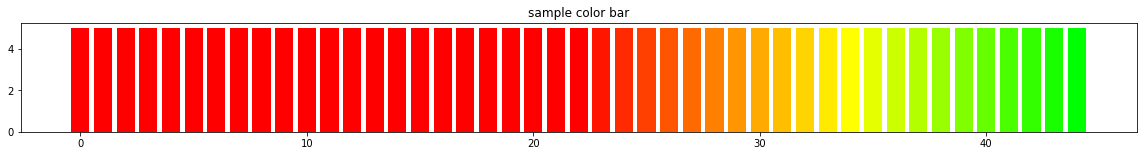

In [13]:
#to show the color bar and show how will the color works for the score which range from 0 to 44
color_bar=[]
for i in range(45):
    color_bar.append(getcolor(i))
print(color_bar[-1])
plt.figure(figsize=(20, 2))
plt.title('sample color bar')
plt.bar(range(45),5,color=color_bar)

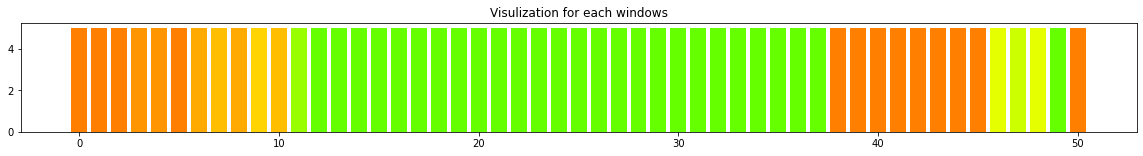

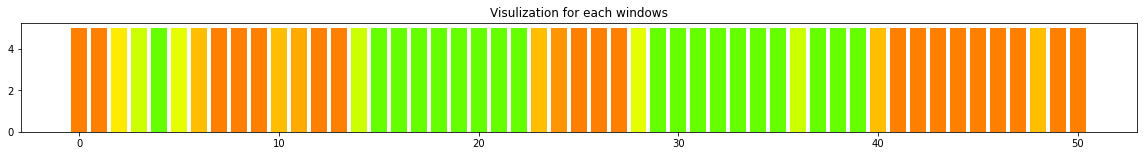

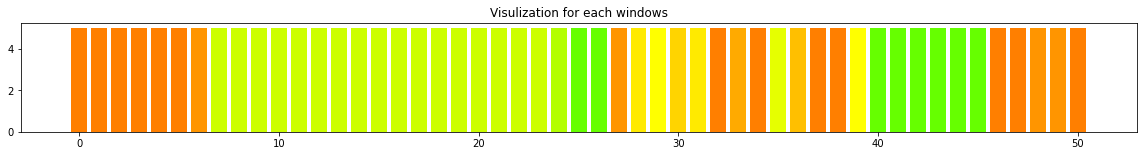

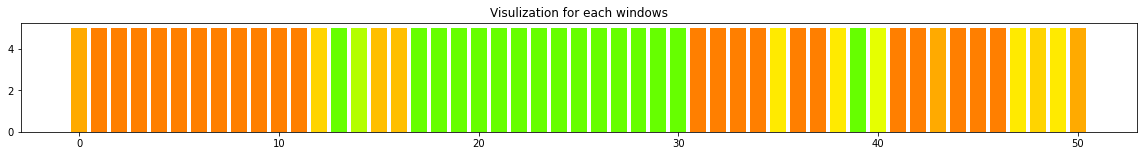

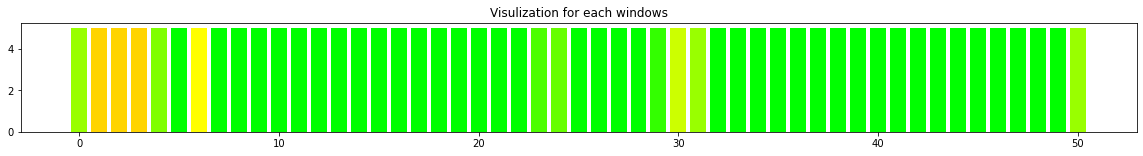

In [14]:
#simply show some sample for the windows quality
def drawbar(start,end,color_list):
    plt.figure(figsize=(20, 2))
    plt.title('Visulization for each windows')
    plt.bar(range(end-start+1),5,color=color_list[start:end])
    
for i in range(5):
    start=i*50
    end=(i+1)*50
    drawbar(start,end,color_windows)

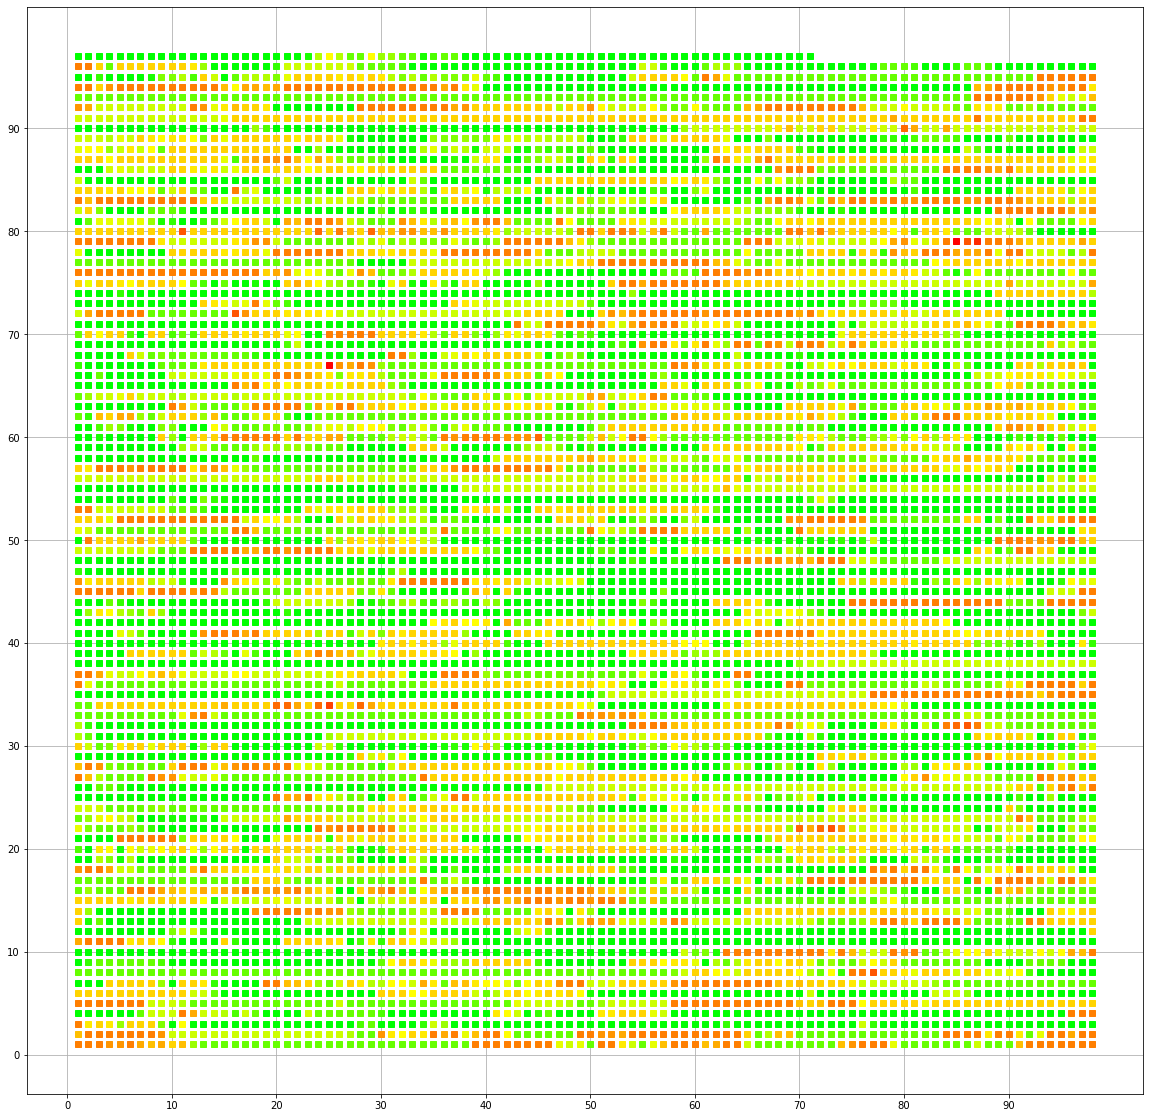

In [15]:
#show the whole windows quality
plt.figure(figsize=(20, 20))
ax = plt.gca()
color_sqrt=int(len(color_windows)**0.5//1+1)
plt.xticks(np.arange(0,color_sqrt,10))
plt.yticks(np.arange(0,color_sqrt,10))
ax.grid()
for yaxis in range(color_sqrt):
    for xaxis in range(color_sqrt):
        state=[xaxis,yaxis]
        index = state[0]+state[1]*color_sqrt
        if(index>=len(color_windows)):
            break
        color= color_windows[index]
        plt.plot(state[0]+1,state[1]+1, linewidth = '1', label = "end", color=color, linestyle=':', marker='s',markersize=6)
plt.show()

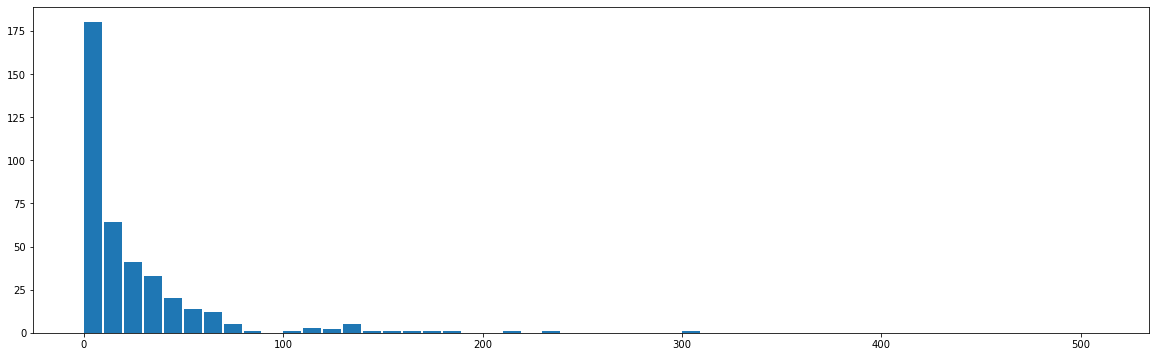

In [16]:
histogram_class=[0]*51
for keys,values in windows_count_per_patient.items():
    histogram_index=values//10
    if histogram_index<=50:
        histogram_class[histogram_index]+=1
    else:
        histogram_class[50]+=1
histogram_label=[]
for i in range(51):
    histogram_label.append(str(i*10))
plt.figure(figsize=(20, 6))
plt.bar((pd.Series(list(map(int, histogram_label)))+4.5).tolist(), histogram_class, width=9)
plt.show()

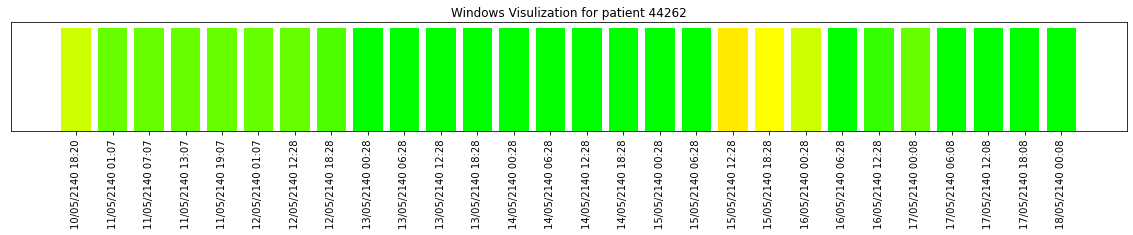

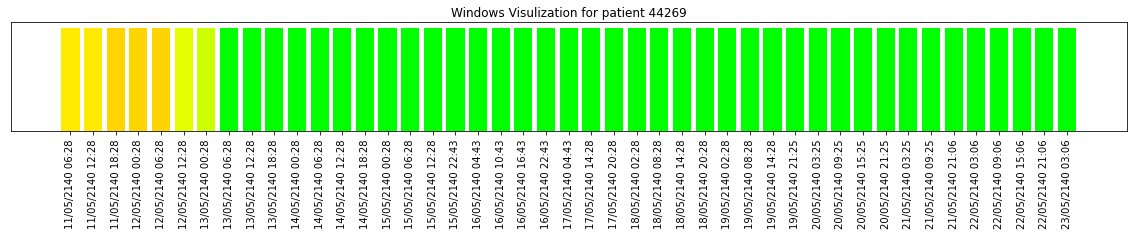

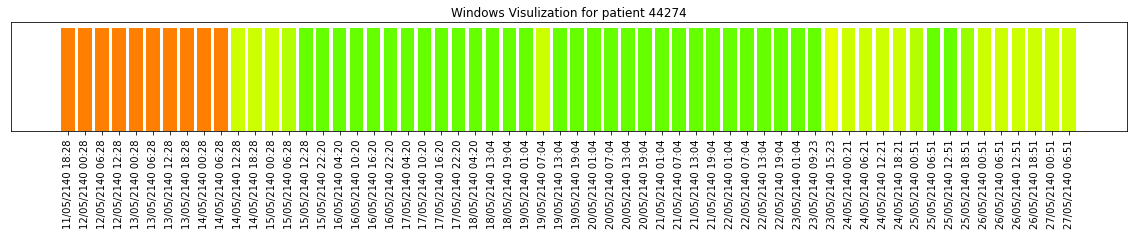

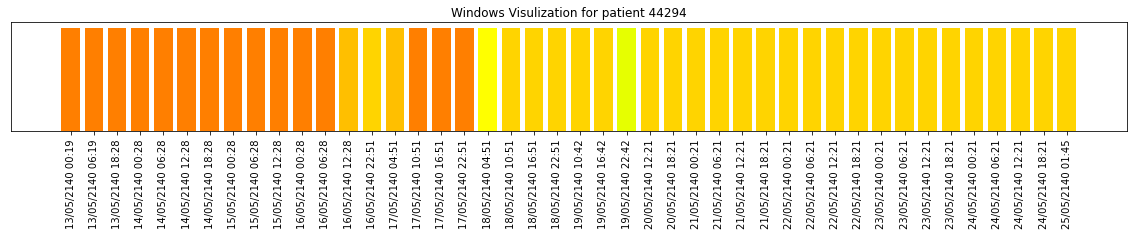

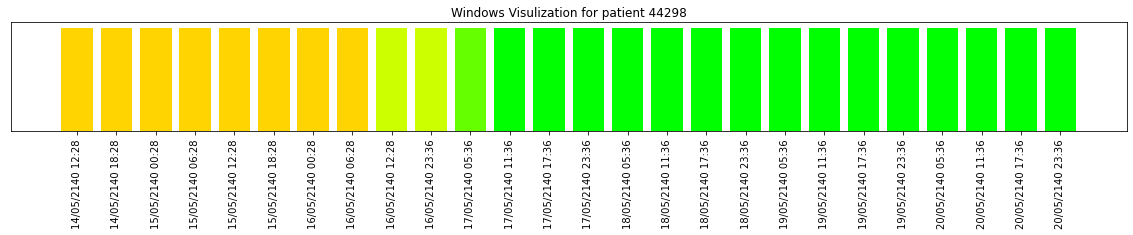

In [17]:
def drawbar_patient(windows_count_per_patient,patient,color_list):
    patient_windows=list(windows_count_per_patient.keys())
    windows_count=list(windows_count_per_patient.values())
    patient_index=patient_windows.index(patient)
    windows_start=sum(windows_count[:patient_index])
    windows_end=sum(windows_count[:patient_index+1])
    windows_start_time=list(dropped_windows_mark_df['Start_Time'])[windows_start:windows_end]
    plt.figure(figsize=(20, 2))
    #plt.figure(figsize=(2, 20))
    plt.yticks([])
    plt.xticks(rotation=90)
    plt.title('Windows Visulization for patient '+str(patient))
    plt.bar(windows_start_time,5,color=color_list[windows_start:windows_end])
    plt.show()
    
patient_draw=list(windows_count_per_patient.keys())[13:18]
for patient in patient_draw:
    drawbar_patient(windows_count_per_patient,patient,color_windows)

In [18]:
def get_windows_count(df):
    windows_count = (df.shape[0])/windows_size
    return (int(windows_count))

patient_for_windows=list(windows_count_per_patient.keys())
print(patient_for_windows)

[44162, 44165, 44170, 44171, 44172, 44185, 44197, 44208, 44216, 44230, 44239, 44240, 44255, 44262, 44269, 44274, 44294, 44298, 44299, 44367, 44375, 44380, 44408, 44424, 44443, 44448, 44450, 44453, 44454, 44530, 44535, 44536, 44538, 44544, 44560, 44586, 44614, 44623, 44632, 44637, 44646, 44647, 44654, 44660, 44664, 44668, 44674, 44679, 44683, 44696, 44700, 44702, 44707, 44708, 44713, 44720, 44726, 44730, 44741, 44762, 44765, 44778, 44787, 44794, 44812, 44815, 44821, 44828, 44833, 44835, 44852, 44854, 44860, 44868, 44871, 44874, 44889, 44912, 44930, 44933, 44940, 44943, 44948, 44971, 44979, 45008, 45009, 45019, 45026, 45031, 45050, 45056, 45084, 45086, 45099, 45102, 45104, 45110, 45111, 45116, 45121, 45144, 45160, 45177, 45181, 45183, 45184, 45187, 45193, 45198, 45211, 45212, 45262, 45266, 45267, 45268, 45277, 45284, 45285, 45297, 45300, 45305, 45320, 45322, 45328, 45331, 45333, 45336, 45338, 45367, 45379, 45380, 45384, 45404, 45414, 45437, 45440, 45446, 45457, 45468, 45469, 45476, 45494

In [19]:
def get_windows_by_patient(patient,windows_count_per_patient=windows_count_per_patient,windows_df=windows_df):
    patient_windows=list(windows_count_per_patient.keys())
    windows_count=list(windows_count_per_patient.values())
    patient_index=patient_windows.index(patient)
    windows_start=sum(windows_count[:patient_index])
    windows_end=sum(windows_count[:patient_index+1])
    return(windows_df[windows_start*windows_size:windows_end*windows_size])
#patient can be picked from patient_for_windows
windows_from_44298 = get_windows_by_patient(patient_for_windows[0])
display(windows_from_44298)
print(get_windows_count(windows_from_44298))

,Time,ID,AdmissionDate,DischargeDate,CCOutcome,HospOutcome,VentMode,PS_Above_PEEP,EPAP_PEEP,SET_FIO2,...,PH,PaCO2,PaO2,LactateABG,HeartRate,ArtSystollic,ArtMAP,Temperature,empty_col,timestamps
0,02/05/2140 08:21,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,15.0,90.0,...,NaN,NaN,NaN,NaN,105.0,119.0,79.0,NaN,,5.375230e+09
1,02/05/2140 08:22,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,15.0,90.0,...,NaN,NaN,NaN,NaN,105.0,118.0,78.0,NaN,,5.375230e+09
2,02/05/2140 08:23,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,15.0,90.0,...,NaN,NaN,NaN,NaN,106.0,114.0,75.0,NaN,,5.375230e+09
3,02/05/2140 08:24,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,15.0,90.0,...,NaN,NaN,NaN,NaN,106.0,116.0,76.0,NaN,,5.375230e+09
4,02/05/2140 08:25,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,15.0,90.0,...,NaN,NaN,NaN,NaN,105.0,118.0,78.0,NaN,,5.375230e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13675,12/05/2140 05:21,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PS/CPAP,0,8.0,25.0,...,NaN,NaN,NaN,NaN,109.0,121.0,86.0,NaN,,5.376083e+09
13676,12/05/2140 05:22,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PS/CPAP,0,8.0,25.0,...,NaN,NaN,NaN,NaN,118.0,125.0,93.0,NaN,,5.376083e+09
13677,12/05/2140 05:23,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PS/CPAP,0,8.0,25.0,...,NaN,NaN,NaN,NaN,108.0,141.0,100.0,NaN,,5.376083e+09
13678,12/05/2140 05:24,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PS/CPAP,0,8.0,25.0,...,NaN,NaN,NaN,NaN,123.0,136.0,101.0,NaN,,5.376083e+09


38


In [20]:
def get_windows_by_color(size=0,score_color=score_color,windows_df=windows_df,color_score_range=[]):
    index_list_for_score = [x for x, y in list(enumerate(score_color)) if y in color_score_range]
    if size<= len(index_list_for_score) and size>0:
        index_list_for_score = sample(index_list_for_score, size)#from random import sample, to get random index_list
    windows_concat_lst=[]
    for i in index_list_for_score:
        if i < len(windows_df)-windows_size:
            windows_concat_df = windows_df[i*windows_size:i*windows_size+windows_size]
            windows_concat_lst.append(windows_concat_df)
    windows_by_color=pd.concat(windows_concat_lst)
    return(windows_by_color)

windows_by_color=get_windows_by_color(color_score_range=list(range(32,44)))
display(windows_by_color)
print(get_windows_count(windows_by_color))

,Time,ID,AdmissionDate,DischargeDate,CCOutcome,HospOutcome,VentMode,PS_Above_PEEP,EPAP_PEEP,SET_FIO2,...,PH,PaCO2,PaO2,LactateABG,HeartRate,ArtSystollic,ArtMAP,Temperature,empty_col,timestamps
3240,04/05/2140 14:21,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,12.0,55.0,...,NaN,NaN,NaN,NaN,107.0,120.0,75.0,NaN,,5.375424e+09
3241,04/05/2140 14:22,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,12.0,55.0,...,NaN,NaN,NaN,NaN,108.0,120.0,76.0,NaN,,5.375424e+09
3242,04/05/2140 14:23,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,12.0,55.0,...,NaN,NaN,NaN,NaN,108.0,119.0,75.0,NaN,,5.375424e+09
3243,04/05/2140 14:24,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,12.0,55.0,...,NaN,NaN,NaN,NaN,107.0,119.0,75.0,NaN,,5.375424e+09
3244,04/05/2140 14:25,44162,01/05/2140 21:34,13/05/2140 10:53,A,<NA>,PRVC,<NA>,12.0,55.0,...,NaN,NaN,NaN,NaN,109.0,121.0,77.0,NaN,,5.375424e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3400195,29/05/2141 05:41,48017,24/04/2141 21:15,13/06/2141 10:37,A,A,PRVC+VS Trig,<NA>,10.0,35.0,...,NaN,NaN,NaN,NaN,73.0,148.0,92.0,NaN,,5.409089e+09
3400196,29/05/2141 05:42,48017,24/04/2141 21:15,13/06/2141 10:37,A,A,PRVC+VS Trig,<NA>,10.0,100.0,...,NaN,NaN,NaN,NaN,71.0,144.0,88.0,NaN,,5.409089e+09
3400197,29/05/2141 05:43,48017,24/04/2141 21:15,13/06/2141 10:37,A,A,PRVC+VS Trig,<NA>,10.0,100.0,...,NaN,NaN,NaN,NaN,68.0,151.0,94.0,NaN,,5.409089e+09
3400198,29/05/2141 05:44,48017,24/04/2141 21:15,13/06/2141 10:37,A,A,PRVC+VS Trig,<NA>,10.0,35.0,...,NaN,NaN,NaN,NaN,66.0,158.0,95.0,NaN,,5.409089e+09


5022


In [21]:
windows_by_color.to_csv('good_windows_df_360.csv',index=False,header=True)

FileNotFoundError: [Errno 2] No such file or directory: 'Train_models/good_windows_df_360.csv'

In [ ]:
def get_windows_by_color_from_patient(patient,color_score_range=[],size=0,
                                      windows_count_per_patient=windows_count_per_patient,windows_df=windows_df,score_color=score_color):
    windows_from_patient = get_windows_by_patient(patient,windows_count_per_patient=windows_count_per_patient,windows_df=windows_df)
    windows_from_patient_index = list(windows_from_patient.index)
    start_index = round(windows_from_patient_index[0]/windows_size)
    end_index = round(windows_from_patient_index[-1]/windows_size)
    print(start_index,end_index)
    score_color_from_patient = score_color[start_index:(end_index+1)]
    windows_by_color_from_patient = get_windows_by_color(size=size,score_color=score_color_from_patient,
                                                         windows_df=windows_from_patient,color_score_range=color_score_range)
    return(windows_by_color_from_patient)

windows_by_color44_from_patient44269=get_windows_by_color_from_patient(44240,color_score_range=list(range(36,44)))
display(windows_by_color44_from_patient44269)
print(get_windows_count(windows_by_color44_from_patient44269))
    

197 308


,Time,ID,AdmissionDate,DischargeDate,CCOutcome,HospOutcome,VentMode,PS_Above_PEEP,EPAP_PEEP,SET_FIO2,...,PH,PaCO2,PaO2,LactateABG,HeartRate,ArtSystollic,ArtMAP,Temperature,empty_col,timestamps
72000,12/05/2140 04:34,44240,09/05/2140 08:02,04/07/2140 12:25,A,A,PRVC+VS Trig,<NA>,8.0,30.0,...,NaN,NaN,NaN,NaN,81.0,166.0,101.0,NaN,,5.376080e+09
72001,12/05/2140 04:35,44240,09/05/2140 08:02,04/07/2140 12:25,A,A,PRVC+VS No Trig,<NA>,8.0,30.0,...,NaN,NaN,NaN,NaN,81.0,168.0,103.0,NaN,,5.376080e+09
72002,12/05/2140 04:36,44240,09/05/2140 08:02,04/07/2140 12:25,A,A,PRVC+VS No Trig,<NA>,8.0,30.0,...,NaN,NaN,NaN,NaN,81.0,169.0,103.0,NaN,,5.376080e+09
72003,12/05/2140 04:37,44240,09/05/2140 08:02,04/07/2140 12:25,A,A,PRVC+VS No Trig,<NA>,8.0,30.0,...,NaN,NaN,NaN,NaN,81.0,168.0,103.0,NaN,,5.376080e+09
72004,12/05/2140 04:38,44240,09/05/2140 08:02,04/07/2140 12:25,A,A,PRVC+VS No Trig,<NA>,8.0,30.0,...,NaN,NaN,NaN,NaN,80.0,165.0,101.0,NaN,,5.376080e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110875,27/06/2140 10:06,44240,09/05/2140 08:02,04/07/2140 12:25,A,A,PS/CPAP,0,7.5,25.0,...,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,,5.380074e+09
110876,27/06/2140 10:07,44240,09/05/2140 08:02,04/07/2140 12:25,A,A,PS/CPAP,0,7.5,25.0,...,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,,5.380074e+09
110877,27/06/2140 10:08,44240,09/05/2140 08:02,04/07/2140 12:25,A,A,PS/CPAP,0,7.5,25.0,...,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,,5.380074e+09
110878,27/06/2140 10:09,44240,09/05/2140 08:02,04/07/2140 12:25,A,A,PS/CPAP,0,7.5,25.0,...,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,,5.380075e+09


16
